# ML Airline - No Differencing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
df = pd.read_csv('../Data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df['LogPassengers'] = np.log(df['Passengers'])

In [5]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [6]:
# Create a machine learniung dataset
series = df['LogPassengers'].to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)

print("X.shape ", X.shape, "Y.shape ", Y.shape)


X.shape  (134, 10) Y.shape  (134,)


In [7]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [8]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.9599443783339897

In [9]:
lr.score(Xtest, Ytest)

0.691095304456559

In [10]:
# Crfeate a boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False

In [11]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

In [12]:
df.tail()

,Passengers,LogPassengers,LR_1step_train,LR_1step_test
Month,,,,
1960-08-01,606,6.406880,NaN,6.315170
1960-09-01,508,6.230481,NaN,6.305534
1960-10-01,461,6.133398,NaN,6.176992
1960-11-01,390,5.966147,NaN,6.057768
1960-12-01,432,6.068426,NaN,5.945701


<Axes: xlabel='Month'>

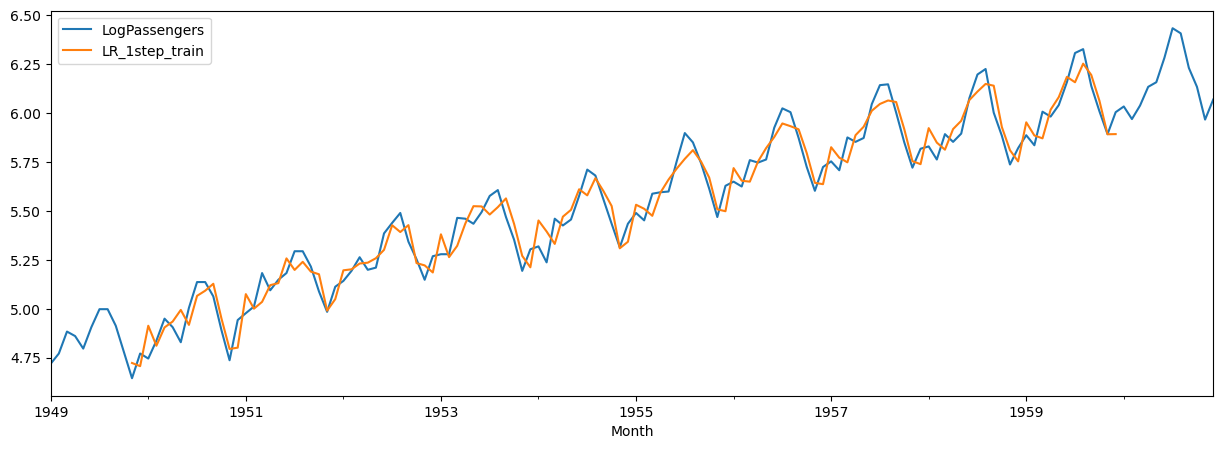

In [13]:
df[['LogPassengers', 'LR_1step_train']].plot(figsize=(15,5))

In [14]:
df.tail()

,Passengers,LogPassengers,LR_1step_train,LR_1step_test
Month,,,,
1960-08-01,606,6.406880,NaN,6.315170
1960-09-01,508,6.230481,NaN,6.305534
1960-10-01,461,6.133398,NaN,6.176992
1960-11-01,390,5.966147,NaN,6.057768
1960-12-01,432,6.068426,NaN,5.945701


## Multi Step Forcast

In [15]:
multistep_predictions = []

#first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = lr.predict(last_x.reshape(1, -1))[0]
    
    # update the predicts list
    multistep_predictions.append(p)
    
    # make a newe input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
    

In [16]:
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

<Axes: xlabel='Month'>

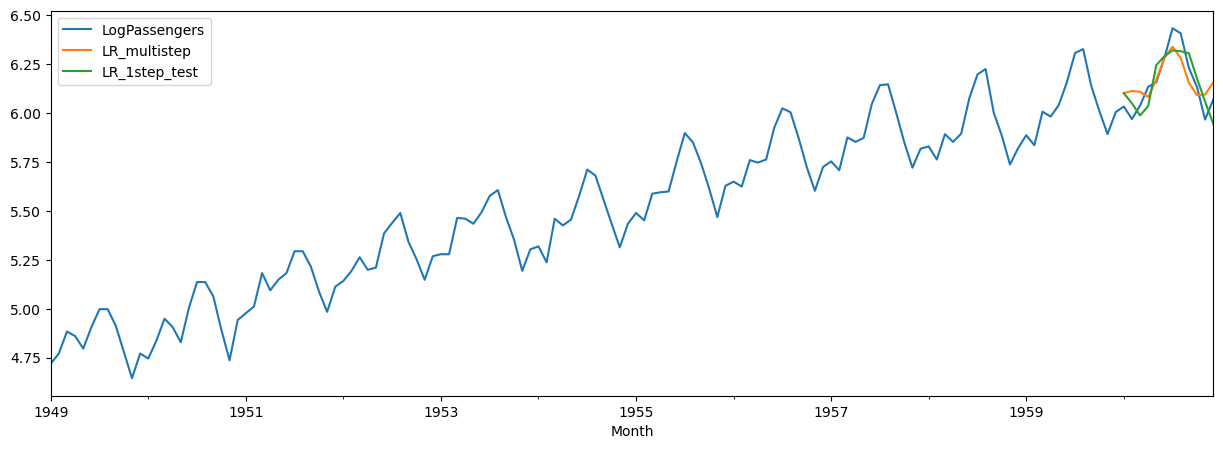

In [17]:
df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15,5))

## Multi-output Model

In [18]:
Tx = T
Ty = Ntest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)
    
X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (123, 10) Y.shape (123, 12)


In [19]:
# Y

In [20]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [21]:
# Xtrain

In [22]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.9734607773512528

In [23]:
# SST equals zero so R2 cant be calculated
# lr.score(Xtest_m, Ytest_m)

In [24]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.801874967671522

In [25]:
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

In [26]:
df.tail()

,Passengers,LogPassengers,LR_1step_train,LR_1step_test,LR_multistep,LR_multioutput
Month,,,,,,
1960-08-01,606,6.406880,NaN,6.315170,6.280921,6.393816
1960-09-01,508,6.230481,NaN,6.305534,6.155062,6.224522
1960-10-01,461,6.133398,NaN,6.176992,6.090944,6.084452
1960-11-01,390,5.966147,NaN,6.057768,6.094249,5.992843
1960-12-01,432,6.068426,NaN,5.945701,6.155635,6.078878


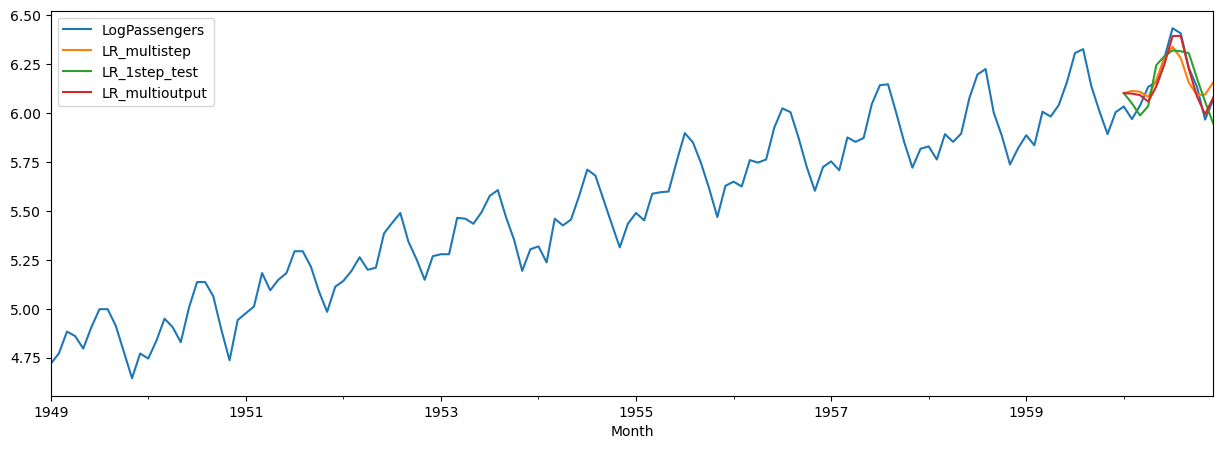

In [27]:
# plot all forecasts
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15,5));

In [28]:
# MAPE
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("multi-step MAPE", mape1)
mape2 = mean_absolute_percentage_error(Ytest, df.loc[test_idx, 'LR_multioutput'])
print("multi-step MAPE", mape2)

multi-step MAPE 0.01222932502347539
multi-step MAPE 0.0071789244750397885


## Test Other Models

In [33]:
# function to test other ML models

def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)
    # print("Train R^2:", model.score(Xtrain, Ytrain))
    # print("Test R^2:", model.score(Xtest, Ytest))
    
    # store 1-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
    df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)
    
    # generate multi-step forecast
    multistep_predictions = []
    
    # first test input
    last_x = Xtest[0]
    
    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1, -1))[0]
        
        # update the predictions list 
        multistep_predictions.append(p)
        
        # make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p
    
    # store the multi-step forecast
    df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions
    
    # MAPE for mmultistep forecast
    mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
    print("Test MAPE (multi-step)", mape)
    
    # plot 1-step and multi-step forecasts
    cols = ['LogPassengers', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']
    df[cols].plot(figsize=(15,5));
    

One-step forecast: SVR
Test MAPE (multi-step) 0.017529446164230467


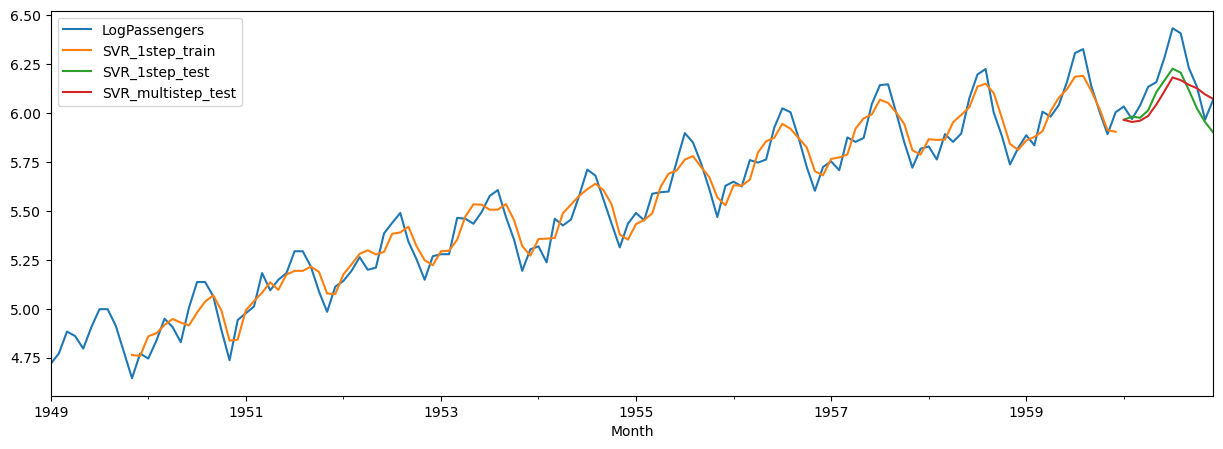

In [34]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step) 0.030009725040496205


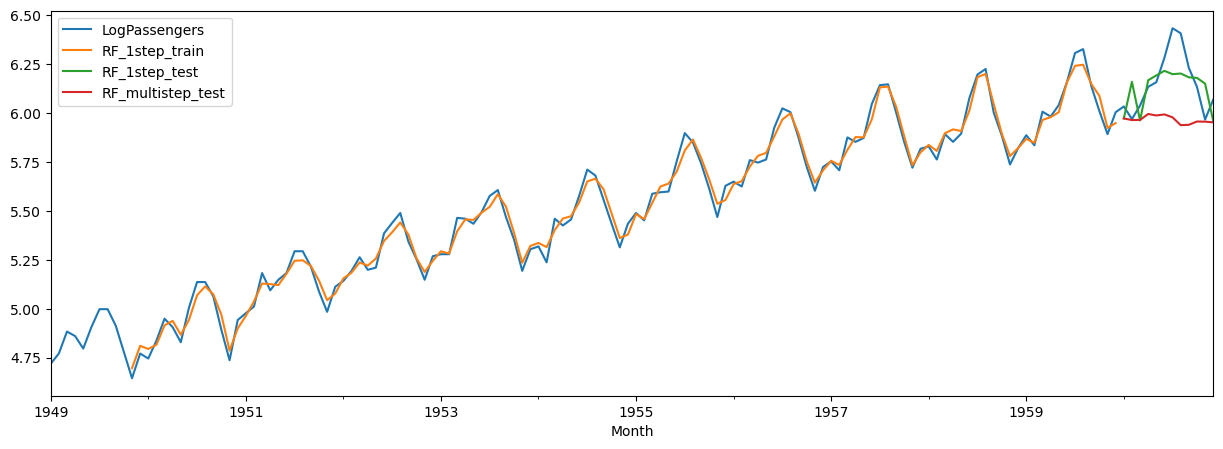

In [35]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [32]:
# stopped at 12:08